# Hybrid Brain Tumor Classifier (EfficientNet + Advanced Preprocessing)
This notebook is fine-tuned for Google Colab and combines EfficientNet's power with advanced brain cropping and augmentation for high-accuracy multi-class brain tumor detection.
All code blocks are labeled by section and function, with detailed comments and visualizations.

In [44]:
# Create the parent directory for the mount point if it doesn't exist
!mkdir -p /content/mnt

from google.colab import drive
drive.mount('/content/mnt/drive', force_remount=True)

Mounted at /content/mnt/drive


In [ ]:
# Install required packages for Colab
!pip install timm --quiet
!pip install opencv-python --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.1 MB/s eta 0:00:00


In [39]:
# SECTION 1: Environment Setup and Imports
# ----------------------------------------

# Import libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import copy
import time

# Enable inline plotting for Colab
%matplotlib inline

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


***Advanced Brain Cropping In Preprocessing***

In [40]:
## SECTION 2: Brain Cropping Preprocessing
# This function crops the brain region from MRI images using contour detection, as inspired by the VGG-16 notebook.

def crop_brain(img, add_pixels=0):
    """
    Crops the brain region from an MRI image using contour detection.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    cropped = img[max(extTop[1]-add_pixels,0):extBot[1]+add_pixels, max(extLeft[0]-add_pixels,0):extRight[0]+add_pixels].copy()
    return cropped

***Cropping Augmentation Preprocessing Step 2***

In [41]:
## SECTION 3: Custom Dataset with Cropping and Augmentation
# This dataset class applies brain cropping and strong augmentations for training, and only cropping and normalization for validation.

class BrainTumorDataset(Dataset):
    """
    Custom PyTorch Dataset for brain tumor images with cropping and augmentation.
    """
    def __init__(self, filepaths, labels, class_to_idx, augment=False):
        self.filepaths = filepaths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.augment = augment
        # Define standard transformations for validation/testing
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # Define augmentation transformations for training
        self.aug_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
            transforms.ColorJitter(brightness=0.5, contrast=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        # Read and preprocess image
        img = cv2.imread(self.filepaths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = crop_brain(img) # Apply brain cropping

        # Apply transformations based on augmentation flag
        if self.augment:
            img = self.aug_transform(img)
        else:
            img = self.transform(img)

        # Get label index
        label = self.class_to_idx[self.labels[idx]]

        return img, label

***Feature Extraction and Regularization***

In [42]:
## SECTION 4: EfficientNetB3 Model with Advanced Head
# This model uses EfficientNetB3 as a feature extractor and adds a regularized classification head.

class HybridEffNet(nn.Module):
    """
    EfficientNetB3-based classifier with advanced regularized head.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.base = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0, global_pool='avg')
        self.bn = nn.BatchNorm1d(self.base.num_features)
        self.head = nn.Sequential(
            nn.Linear(self.base.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.base(x)
        x = self.bn(x)
        x = self.head(x)
        return x

***SECTION 4.5: Zipped Extract Dataset***


In [34]:
# import zipfile
# import os

# # Define the path to your zipped dataset on Google Drive
# zip_path = '/content/drive/MyDrive/Colab_Notebooks/MRI_Scans_organized_dataset.zip'

In [45]:
import os

# Get the directory path from the zip_path
zip_path = '/content/mnt/drive/MyDrive/Dataset_Train/MRI_Scans_organized_dataset_extracted'
zip_dir = os.path.dirname(zip_path)

print(f"Listing files in: {zip_dir}")

# List files in the directory
if os.path.exists(zip_dir):
    for item in os.listdir(zip_dir):
        print(item)
else:
    print(f"Directory not found: {zip_dir}")

Listing files in: /content/mnt/drive/MyDrive/Dataset_Train
MRI_Scans_organized_dataset.zip
MRI_Scans_organized_dataset


In [50]:
import zipfile
import os

# Define the path to your zipped dataset on Google Drive
# zip_path = '/content/drive/MyDrive/Colab_Notebooks/MRI_Scans_organized_dataset.zip'  # Example path - UPDATE THIS!
zip_path = '/content/mnt/drive/MyDrive/Dataset_Train/MRI_Scans_organized_dataset.zip'

# Define the directory where you want to extract the dataset
# This will create a new folder next to your zip file or you can specify a different path
extracted_path = '/content/mnt/drive/MyDrive/Dataset_Train/MRI_Scans_organized_dataset_extracted'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extracted_path):
    os.makedirs(extracted_path)
    print(f"Created extraction directory: {extracted_path}")

# Extract the zip file
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Successfully extracted {zip_path} to {extracted_path}")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_path}")
except zipfile.BadZipFile:
    print(f"Error: Could not open zip file {zip_path}. It might be corrupted.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Successfully extracted /content/mnt/drive/MyDrive/Dataset_Train/MRI_Scans_organized_dataset.zip to /content/mnt/drive/MyDrive/Dataset_Train/MRI_Scans_organized_dataset_extracted


***Data Prep and Visualisation.***

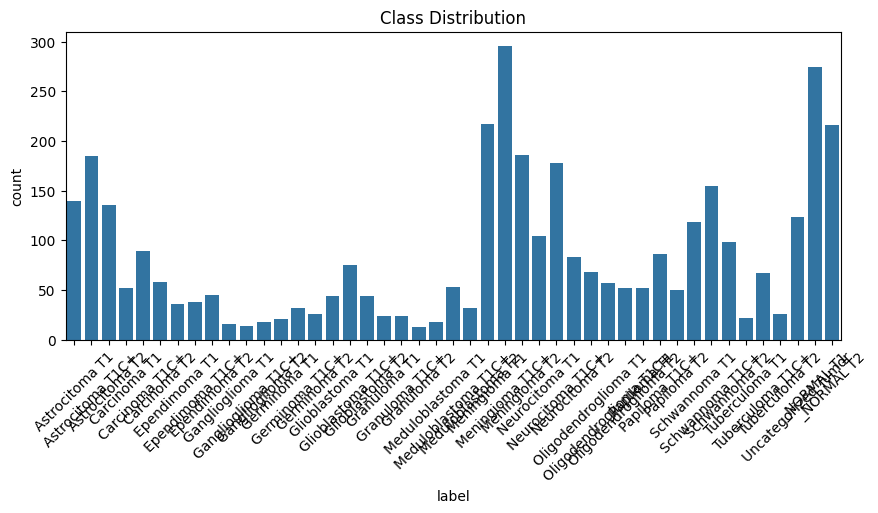

Number of training samples: 3008
Number of validation samples: 753
Number of classes: 45


In [56]:
## SECTION 5: Data Preparation and Visualization
# This section loads file paths and labels, splits the data, and visualizes class distribution.

def get_filepaths_and_labels(root_dir):
    """
    Scans the root directory for images and returns filepaths, labels, and class-to-index mapping.
    """
    filepaths, labels = [], []
    class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    for class_name in class_names:
        class_dir = os.path.join(root_dir, class_name)
        for fname in os.listdir(class_dir):
            # Include more common image file extensions
            if fname.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tiff', '.JPG', '.PNG', '.JPEG', '.BMP', '.TIFF')):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(class_name)
    return filepaths, labels, {c: i for i, c in enumerate(class_names)}

# Set your data directory here (update for your Colab environment)
# Make sure to mount your Google Drive and update this path accordingly
# root_dir = '/content/drive/MyDrive/Colab Notebooks/MRI_Scans_organized_dataset.zip'  # Example path - UPDATE THIS!
# root_dir = extracted_path # Use the path where the zip file was extracted
root_dir = os.path.join(extracted_path, 'MRI_Scans_organized_dataset', 'train') # Point to the training data directory within the extracted path

# Load filepaths and labels
filepaths, labels, class_to_idx = get_filepaths_and_labels(root_dir)

# Visualize class distribution
import pandas as pd
import seaborn as sns
df = pd.DataFrame({'label': labels})
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='label', order=sorted(df['label'].unique()))
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

# Split into train and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.2, stratify=labels, random_state=42
)
num_classes = len(class_to_idx)

print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")
print(f"Number of classes: {num_classes}")

***Data Loading and Sample Visualization***

Training DataLoader batch size: 32
Validation DataLoader batch size: 32


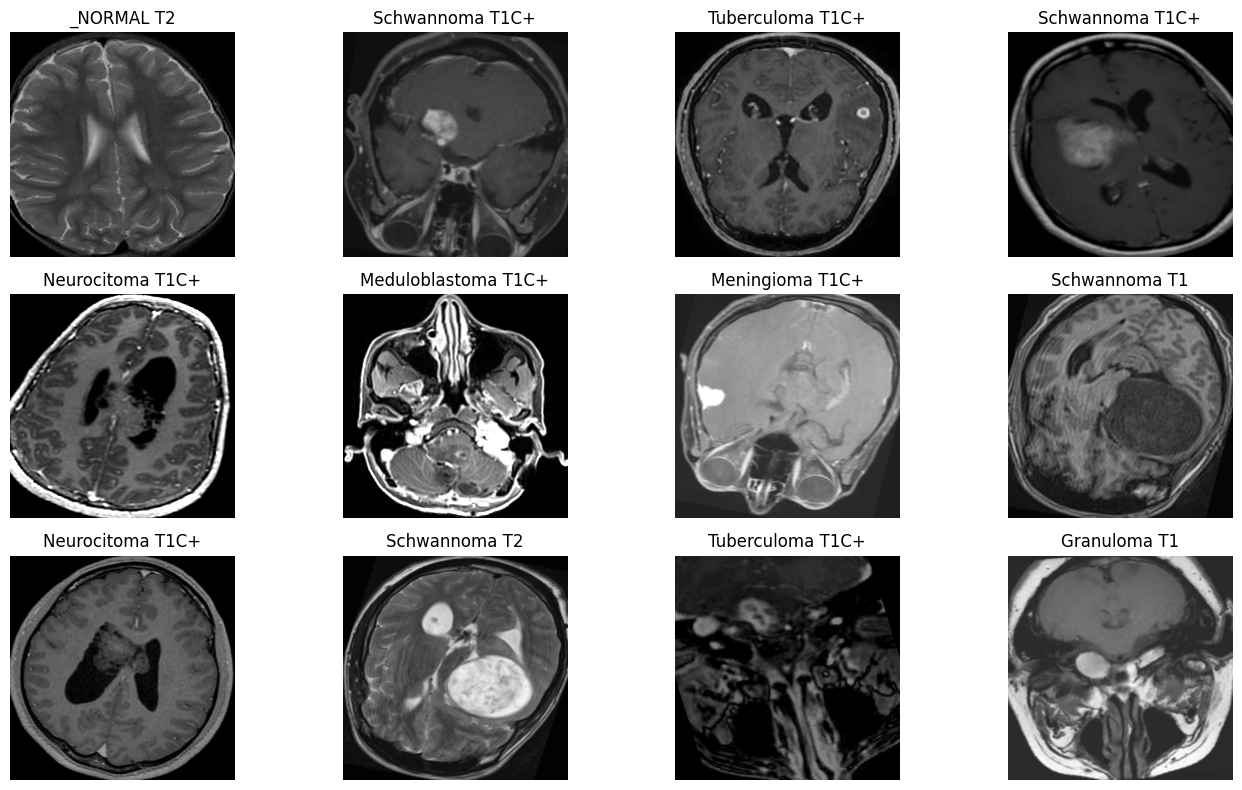

In [58]:
## SECTION 6: DataLoader Setup and Sample Visualization
# This section creates PyTorch DataLoaders and visualizes a batch of augmented training images.

# Create datasets and dataloaders
train_ds = BrainTumorDataset(train_files, train_labels, class_to_idx, augment=True)
val_ds = BrainTumorDataset(val_files, val_labels, class_to_idx, augment=False)

# Define batch size - Adjust based on your Colab's GPU memory
batch_size = 32

# Create DataLoaders
# num_workers > 0 can speed up data loading, but be mindful of Colab's RAM limits
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training DataLoader batch size: {train_loader.batch_size}")
print(f"Validation DataLoader batch size: {val_loader.batch_size}")


# Visualize a batch of augmented training images
def show_batch(loader, class_to_idx):
    images, labels = next(iter(loader))
    plt.figure(figsize=(14, 8))
    # Ensure we don't try to display more images than are in the batch
    num_images_to_show = min(12, images.size(0))
    for i in range(num_images_to_show):
        plt.subplot(3, 4, i+1)
        # Unnormalize image for display
        img = images[i].permute(1,2,0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1) # Clip values to be between 0 and 1
        plt.imshow(img)
        label_idx = labels[i].item()
        # Get class name from index
        class_names = list(class_to_idx.keys())
        plt.title(class_names[label_idx])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show a batch from the training loader
show_batch(train_loader, class_to_idx)

***Model Training and Early Stopping***

In [60]:
## SECTION 7: Training Utilities (Early Stopping, LR Scheduler)
# Implements early stopping and learning rate scheduling for robust training.

class EarlyStopping:
    """
    Early stopping utility to halt training when validation loss stops improving.
    """
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.best_weights = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_weights = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                model.load_state_dict(self.best_weights)

***Model Training Step 2: Track Loss and Accuracy***

In [61]:
## SECTION 8: Training Loop
# Trains the model, tracks loss and accuracy, and applies early stopping and learning rate scheduling.

# Ensure device is set (defined in SECTION 1)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Removed as it's defined in SECTION 1

model = HybridEffNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
# Using Adamax optimizer with a learning rate and weight decay
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=0.016)
# Learning rate scheduler to reduce LR when validation loss stops improving
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, min_lr=1e-7, verbose=True)
# Early stopping to prevent overfitting
early_stopper = EarlyStopping(patience=7)

# Define number of epochs
num_epochs = 40

# Lists to store training and validation metrics for plotting
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    # Training phase
    model.train() # Set model to training mode
    running_loss, correct, total = 0, 0, 0
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device) # Move data to GPU

        optimizer.zero_grad() # Zero the gradients
        outputs = model(imgs) # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

        # Optional: Print batch progress
        # if (batch_idx + 1) % 10 == 0:
        #     print(f"  Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")


    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    model.eval() # Set model to evaluation mode
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad(): # Disable gradient calculation for validation
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device) # Move data to GPU
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += imgs.size(0)

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Step the learning rate scheduler
    scheduler.step(val_loss)

    # Check for early stopping
    early_stopper(val_loss, model)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Time: {epoch_duration:.2f}s")

    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break

end_time = time.time()
total_training_time = end_time - start_time
print(f"\nTraining finished in {total_training_time:.2f} seconds.")

# Load the best model weights from early stopping
model.load_state_dict(early_stopper.best_weights)
print("Loaded best model weights.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Starting training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40 | Train Loss: 2.9168 | Val Loss: 2.2613 | Train Acc: 0.2600 | Val Acc: 0.4170 | Time: 62.28s
Epoch 2/40 | Train Loss: 1.9328 | Val Loss: 1.6356 | Train Acc: 0.4940 | Val Acc: 0.5764 | Time: 57.93s
Epoch 3/40 | Train Loss: 1.5755 | Val Loss: 1.4256 | Train Acc: 0.5858 | Val Acc: 0.6215 | Time: 57.23s
Epoch 4/40 | Train Loss: 1.3670 | Val Loss: 1.2982 | Train Acc: 0.6443 | Val Acc: 0.6560 | Time: 57.33s
Epoch 5/40 | Train Loss: 1.2544 | Val Loss: 1.2292 | Train Acc: 0.6592 | Val Acc: 0.6773 | Time: 58.12s
Epoch 6/40 | Train Loss: 1.1961 | Val Loss: 1.2926 | Train Acc: 0.6812 | Val Acc: 0.6627 | Time: 57.76s
Epoch 7/40 | Train Loss: 1.1323 | Val Loss: 1.2330 | Train Acc: 0.6975 | Val Acc: 0.6600 | Time: 56.93s
Epoch 8/40 | Train Loss: 1.1342 | Val Loss: 1.2960 | Train Acc: 0.6971 | Val Acc: 0.6494 | Time: 57.10s
Epoch 9/40 | Train Loss: 1.1043 | Val Loss: 1.1392 | Train Acc: 0.7108 | Val Acc: 0.6799 | Time: 56.89s
Epoch 10/40 | Train Loss: 1.0566 | Val Loss: 1.1792 | Train Acc:

***Evaluation and Visualisation.***


--- Evaluation Results ---
                        precision    recall  f1-score   support

        Astrocitoma T1       0.85      1.00      0.92        28
      Astrocitoma T1C+       1.00      0.95      0.97        37
        Astrocitoma T2       0.77      1.00      0.87        27
          Carcinoma T1       1.00      0.90      0.95        10
        Carcinoma T1C+       0.95      1.00      0.97        18
          Carcinoma T2       0.82      0.75      0.78        12
         Ependimoma T1       0.67      0.86      0.75         7
       Ependimoma T1C+       1.00      0.75      0.86         8
         Ependimoma T2       0.50      0.22      0.31         9
      Ganglioglioma T1       0.00      0.00      0.00         3
    Ganglioglioma T1C+       0.00      0.00      0.00         3
      Ganglioglioma T2       0.00      0.00      0.00         4
          Germinoma T1       0.33      0.25      0.29         4
        Germinoma T1C+       0.80      0.67      0.73         6
          G

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


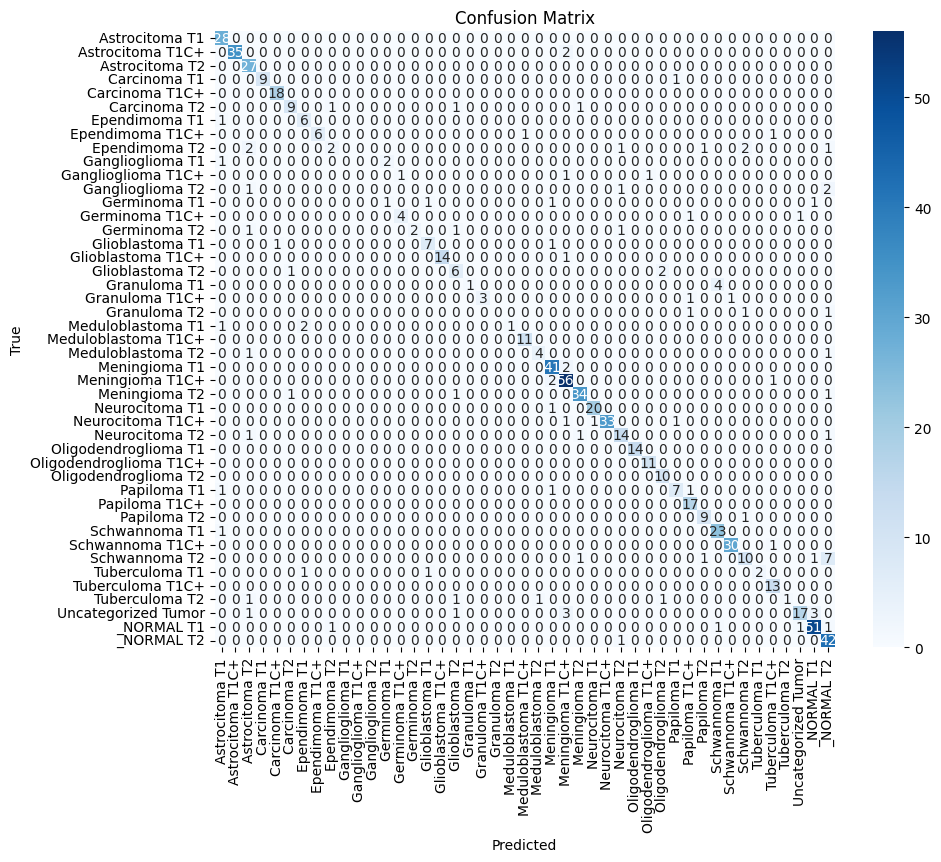

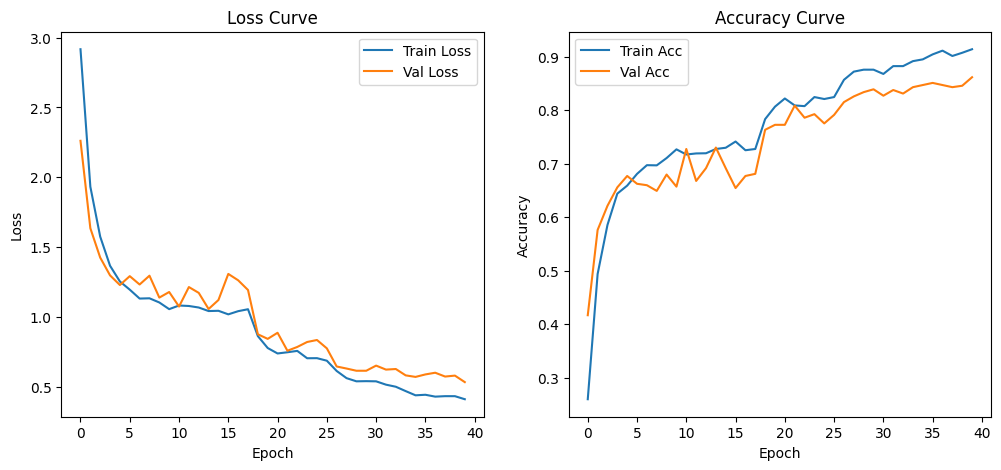

In [62]:
## SECTION 9: Evaluation and Visualization
#  Displays a classification report, confusion matrix, and training curves for detailed model analysis.


# Classification report and confusion matrix
model.eval() # Set model to evaluation mode
all_preds, all_labels = [], []
with torch.no_grad(): # Disable gradient calculation
    for imgs, labels in val_loader:
        imgs = imgs.to(device) # Move data to GPU
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy()) # Move predictions back to CPU for evaluation
        all_labels.extend(labels.numpy())

print("\n--- Evaluation Results ---")
# Generate classification report
print(classification_report(all_labels, all_preds, target_names=list(class_to_idx.keys())))

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_to_idx.keys()), yticklabels=list(class_to_idx.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy Curve')

plt.show()